In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from scipy import io as spio
import numpy as np
import HW01_utils as utils
import trainfunctions as tf

In [10]:
def loaddata_spam(shortpath,_DATA_DIR):
# Load data
    data_dict = spio.loadmat(_DATA_DIR+"\\"+shortpath)
    data = np.array(data_dict['training_data'])
    labels = np.array(data_dict['training_labels'])
    return data,labels

In [5]:
def kfoldPartition(k,data):
    # Partition the shuffled data into k sets
    subsetlen = int(len(data)/k)     #NOTE: This will neglect a few data points if the original data set is not divisible by k (this should be insignificant for large data samples)
    subsets = np.empty((k,subsetlen,len(data[0])))
    for i in range(k):
        subsets[i] = data[i*subsetlen:(i+1)*subsetlen]
    return subsets

In [76]:
_LOCAL_PATH = r"C:\Users\Mitch\Documents\Cal\2 - 2017 Spring\COMPSCI 289A - Intro to Machine Learning\HW01"
_DATA_PATH = "Data\hw01_data"

_DATA_DIR = _LOCAL_PATH + "\\" + _DATA_PATH
datafilepath = r"spam\spam_data.mat"

In [11]:
# Load spam training data (w/ features extracted)
spamdata,labels = loaddata_spam(datafilepath,_DATA_DIR)

# Append labels to the corresponding data (to prevent loss of association when shuffling)
spam = np.c_[spamdata,labels[0]]

#spam_testdata = np.array(spam_dict['test_data'])

# Shuffle data before splitting
np.random.shuffle(spam)

In [12]:
valsetpercent = 20
valsetsize = int(len(spam)*valsetpercent/100)

In [13]:
trainset,valset = utils.partition(valsetsize,spam)
trainsetarrays,trainsetlabels = utils.separatelabels(trainset)
valsetarrays,valsetlabels = utils.separatelabels(valset)

In [14]:
samples = [100, 200, 500, 1000, 2000, len(trainset)]
hyperparams = np.logspace(-8,2,num=20)   #100 was chosen as highest C value here due to time constraints (only marginal improvement in accuracy was seen for C>100)

In [15]:
def kfoldCrossVal(k,data,nsamples,hyperparam):
# Implementation of k-fold Cross-Validation
    spamsets = kfoldPartition(k,data)
    scores = np.zeros(k)
    for i in range(k):
        trainset = spamsets[np.arange(len(spamsets))!=i]
        trainset = np.concatenate(trainset[:])
        valset = spamsets[i]
        scores[i] = tf.TrainAndScoreNsamples(trainset[:nsamples,:-1],trainset[:nsamples,-1],valset[:,:-1],valset[:,-1],hyperparam)
    average = np.sum(scores)/len(scores)
    return average


In [84]:
AccsNoK = np.empty((len(samples)))
i = 0 # sample index counter
for nsamples in samples:
    print(nsamples,'samples')
    hp=1
    acc = tf.TrainAndScoreNsamples(trainsetarrays[:nsamples],trainsetlabels[:nsamples],valsetarrays,valsetlabels,hp)
    print('\tC =',hp,'\tAccuracy:',acc)
    AccsNoK[i] = acc
    i+=1
print(AccsNoK)

100 samples
	C = 1 	Accuracy: 0.772727272727
200 samples
	C = 1 	Accuracy: 0.788201160542
500 samples
	C = 1 	Accuracy: 0.785299806576
1000 samples
	C = 1 	Accuracy: 0.784332688588
2000 samples
	C = 1 	Accuracy: 0.802707930368
4138 samples
	C = 1 	Accuracy: 0.797872340426
[ 0.77272727  0.78820116  0.78529981  0.78433269  0.80270793  0.79787234]


In [93]:
Accs = np.empty((len(samples),len(hyperparams)))
i = 0 # sample index counter
for nsamples in samples:
    print(nsamples,'samples')
    j = 0 # hyperparameter index counter
    for hp in hyperparams:
        acc = kfoldCrossVal(5,spam,nsamples,hp)
    
        print('\tC =',hp,'\tAccuracy:',acc)
        Accs[i,j] = acc
        j+=1
    i+=1
print(Accs)

100 samples
	C = 1e-08 	Accuracy: 0.710058027079
	C = 3.35981828628e-08 	Accuracy: 0.710058027079
	C = 1.12883789168e-07 	Accuracy: 0.710058027079
	C = 3.79269019073e-07 	Accuracy: 0.710058027079
	C = 1.2742749857e-06 	Accuracy: 0.710058027079
	C = 4.28133239872e-06 	Accuracy: 0.710058027079
	C = 1.43844988829e-05 	Accuracy: 0.710058027079
	C = 4.83293023857e-05 	Accuracy: 0.709864603482
	C = 0.000162377673919 	Accuracy: 0.710444874275
	C = 0.000545559478117 	Accuracy: 0.710638297872
	C = 0.00183298071083 	Accuracy: 0.711605415861
	C = 0.00615848211066 	Accuracy: 0.716827852998
	C = 0.0206913808111 	Accuracy: 0.728433268859
	C = 0.0695192796178 	Accuracy: 0.742359767892
	C = 0.233572146909 	Accuracy: 0.754932301741
	C = 0.784759970351 	Accuracy: 0.770406189555
	C = 2.63665089873 	Accuracy: 0.777756286267
	C = 8.8586679041 	Accuracy: 0.786073500967
	C = 29.7635144163 	Accuracy: 0.775628626692
	C = 100.0 	Accuracy: 0.781044487427
200 samples
	C = 1e-08 	Accuracy: 0.710058027079
	C = 3.35

In [17]:
# Find the index of the maximum value in the accuracies table
maxindex = np.array([int(len(Accs)*np.argmax(Accs)/(len(Accs.flatten()))),np.argmax(Accs)%len(Accs[0])])
print('The index of the maximum accuracy ('+str(Accs[maxindex[0],maxindex[1]])+') is:',maxindex)

besthp = hyperparams[maxindex[1]]
bestns = samples[maxindex[0]]
# Determine which sample count-hyperparameter combination this corresponds to
print('This corresponds to a hyperparameter of C = '+ str(besthp) + ' when training on ' + str(bestns) + ' samples.')


The index of the maximum accuracy (0.807543520309) is: [ 4 19]
This corresponds to a hyperparameter of C = 100.0 when training on 2000 samples.


In [86]:
# Load test data
datafilepath = r"spam\spam_data.mat"
spam_dict = spio.loadmat(_DATA_DIR+"\\"+datafilepath)
spam_test = np.array(spam_dict['test_data'])
predictions = tf.TrainAndPredictNsamples(spamdata,labels[0],spam_test,besthp)

In [87]:
IDs = np.arange(len(predictions))
numpycsv = np.c_[IDs,predictions]
np.savetxt(_LOCAL_PATH+r'\spam_testpredictions.csv',numpycsv,fmt='%i',delimiter=',',header='Id,Category',comments='')

In [80]:
from matplotlib import pyplot as plt

In [50]:
hpC1 = 15

In [86]:
errors = np.ones_like(AccsNoK)-AccsNoK

In [87]:
fig = plt.figure()
plt.plot(samples,errors)
plt.title('Error on Datasets of Varying Size')
plt.xlabel('# Training Samples')
plt.ylabel('Error')
plt.text(3500,0.225,'C = 1')

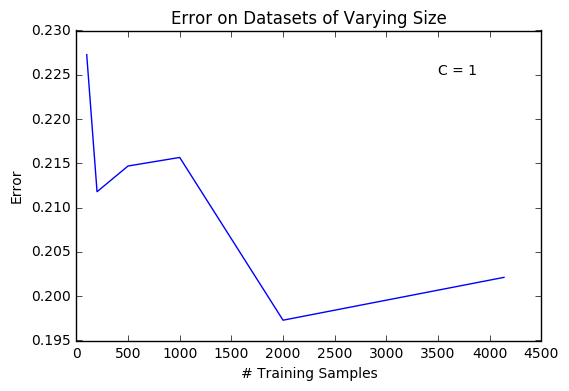

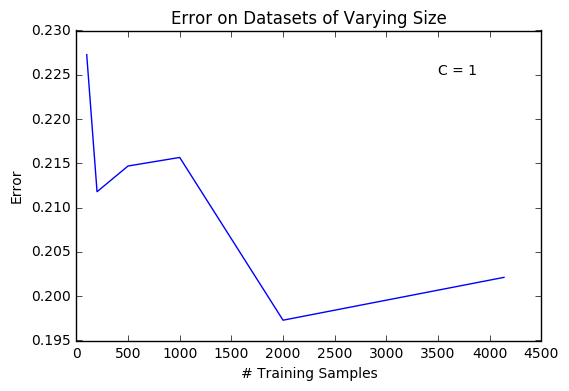

In [88]:
plt.show()

In [89]:
fig.savefig(_LOCAL_PATH+r"\Figures\spam_SampleAcc.jpg")

In [91]:
np.savetxt(_LOCAL_PATH+r'\spam_Accuracies.csv',Accs,fmt='%f',delimiter=',',comments='')
np.savetxt(_LOCAL_PATH+r'\spam_hyperparams.csv',hyperparams,fmt='%.8f',delimiter=',',comments='')

In [94]:
print(Accs)

[[ 0.71005803  0.71005803  0.71005803  0.71005803  0.71005803  0.71005803
   0.71005803  0.7098646   0.71044487  0.7106383   0.71160542  0.71682785
   0.72843327  0.74235977  0.7549323   0.77040619  0.77775629  0.7860735
   0.77562863  0.78104449]
 [ 0.71005803  0.71005803  0.71005803  0.71005803  0.71005803  0.71005803
   0.71005803  0.71005803  0.71025145  0.71102515  0.71644101  0.73017408
   0.74526112  0.75880077  0.76789168  0.78259188  0.78955513  0.79806576
   0.79245648  0.7868472 ]
 [ 0.71005803  0.71005803  0.71005803  0.71005803  0.71005803  0.71005803
   0.71005803  0.71005803  0.71005803  0.7139265   0.7311412   0.74526112
   0.76363636  0.77176015  0.78317215  0.79187621  0.7934236   0.79303675
   0.79245648  0.79245648]
 [ 0.71005803  0.71005803  0.71005803  0.71005803  0.71005803  0.71005803
   0.71005803  0.71005803  0.71141199  0.72572534  0.74119923  0.76189555
   0.77059961  0.78413926  0.7901354   0.79284333  0.79709865  0.79864603
   0.79941973  0.79845261]
 [ 0.

In [95]:
# Export data to csv files for report
np.savetxt(_LOCAL_PATH+r'\spam_Accuracies.csv',Accs,fmt='%f',delimiter=',',comments='')
np.savetxt(_LOCAL_PATH+r'\spam_hyperparams.csv',hyperparams,fmt='%.8f',delimiter=',',comments='')